In [1]:
%%capture
import logging
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["numexpr", "numba", "bokeh", "matplotlib", "tornado", "Comm"],
)

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib
from polars import col

from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.utils import to_describe
from src.plots.plot_stimulus import plot_stimulus_with_shapes

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
def load_configuration(file_path: str) -> dict:
    """Load configuration from a TOML file."""
    file_path = Path(file_path)
    with open(file_path, "rb") as file:
        return tomllib.load(file)


config = load_configuration("src/experiments/measurement/measurement_config.toml")[
    "stimulus"
]


In [4]:
config = {
    "seeds": config["seeds"],
    "sample_rate": config["sample_rate"],
    "half_cycle_num": config["half_cycle_num"],
    "period_range": config["period_range"],
    "amplitude_range": config["amplitude_range"],
    "inflection_point_range": config["inflection_point_range"],
    "shorten_expected_duration": config["shorten_expected_duration"],
    "major_decreasing_half_cycle_num": config["major_decreasing_half_cycle_num"],
    "major_decreasing_half_cycle_period": config["major_decreasing_half_cycle_period"],
    "major_decreasing_half_cycle_amplitude": config[
        "major_decreasing_half_cycle_amplitude"
    ],
    "major_decreasing_half_cycle_min_y_intercept": config[
        "major_decreasing_half_cycle_min_y_intercept"
    ],
    "plateau_num": config["plateau_num"],
    "plateau_duration": config["plateau_duration"],
    "plateau_percentile_range": config["plateau_percentile_range"],
    "prolonged_minima_num": config["prolonged_minima_num"],
    "prolonged_minima_duration": config["prolonged_minima_duration"],
}
assert len(config["seeds"]) == len(set(config["seeds"])), "Seeds must be unique"
assert len(config["seeds"]) == 12, "There must be 12 seeds"

dummy_participant = {
    "temperature_baseline": 47.0,
    "temperature_range": 1.5,  # VAS 0 - VAS 70
}


dummy_config = {
    "seeds": [1, 2, 3],
    "half_cycle_num": 2,
    "period_range": [2, 2],
    "major_decreasing_half_cycle_num": 0,
    "shorten_expected_duration": 0,
    "amplitude_range": [0.9, 1.0],
    "plateau_num": 0,
    "prolonged_minima_num": 0,
}

# Plot one random seed
config.update(dummy_participant)
seed = np.random.randint(0, 1000)
stimulus = StimulusGenerator(config, debug=0, seed=3396)

# print("Plot one random seed:")
plot_stimulus_with_shapes(stimulus)

## Show all stimuli

We want 12 seeds for unpredictable stimuli (note peak-and-end-rule)
- some with plateau in last peak
- some with low end temperature
- no mere sinosiodal patterns

In [5]:
stimuli = pl.concat(
    [
        pl.DataFrame(
            {
                "y": StimulusGenerator(config, seed).y,
                "time": np.arange(len(StimulusGenerator(config, seed).y)),
                "seed": np.array([seed] * len(StimulusGenerator(config, seed).y)),
            }
        )
        for seed in config["seeds"]
    ]
)

stimuli.hvplot(
    x="time",
    y="y",
    kind="line",
    groupby="seed",
    ylim=config["temperature_baseline"]
    + np.array([-1, 1]) * config["temperature_range"] / 2,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'bd19feb0-0cd6-4c19-b0d5-aeedf7ce904d': {'version…

In [6]:
stimuli.group_by("seed", maintain_order=True).agg(to_describe("y"))

seed,y_count,y_null_count,y_mean,y_std,y_min,y_25%,y_50%,y_75%,y_max
i64,u32,u32,f64,f64,f64,f64,f64,f64,f64
133,1800,0,46.923677,0.421417,46.25,46.665601,46.77629,47.232711,47.746504
243,1800,0,46.936088,0.417877,46.25,46.628212,46.89741,47.273344,47.738635
265,1800,0,46.933886,0.440374,46.25,46.596208,46.779867,47.291213,47.744373
396,1800,0,46.970278,0.413692,46.25,46.728107,46.936483,47.308829,47.731835
467,1800,0,46.967071,0.419495,46.25,46.685108,46.972487,47.291938,47.737302
658,1800,0,46.96046,0.41285,46.25,46.621278,46.966524,47.264738,47.704574
681,1800,0,46.932364,0.407685,46.25,46.647874,46.942859,47.242448,47.739538
743,1800,0,46.963318,0.410683,46.25,46.715073,46.884511,47.289045,47.738548
806,1800,0,46.901926,0.438545,46.25,46.566414,46.72672,47.242545,47.749272


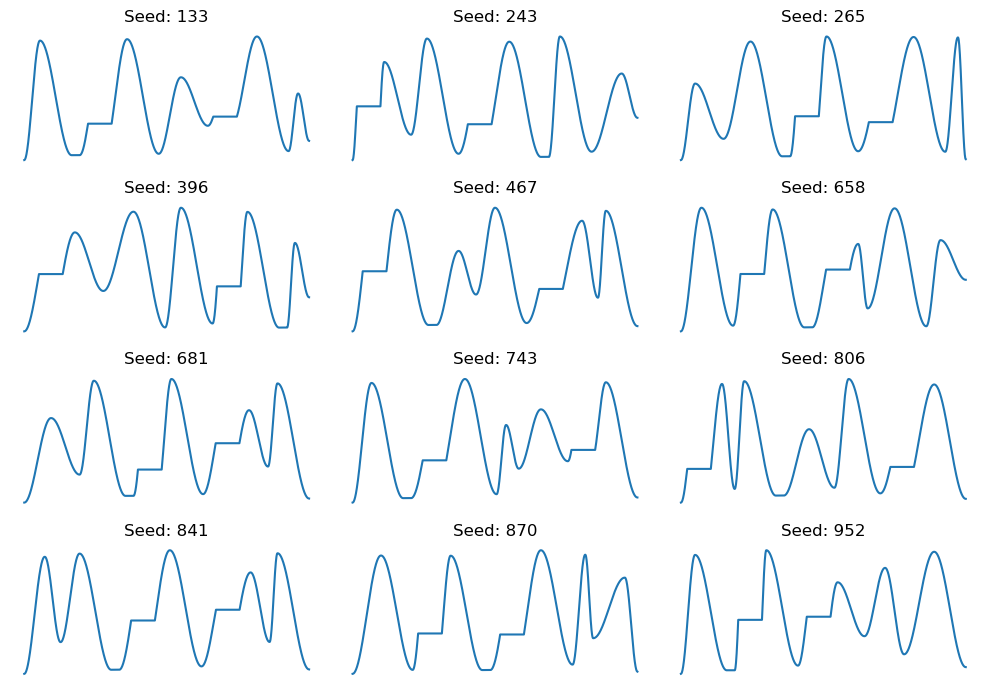

In [7]:
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
axes = axes.flatten()

grouped = stimuli.group_by("seed", maintain_order=True).agg(col("time"), col("y"))
for i, row in enumerate(grouped.to_dicts()):
    ax = axes[i]
    ax.plot(row["time"], row["y"])
    ax.set_title(f"Seed: {row['seed']}")
    ax.axis(False)


plt.tight_layout()
plt.show()

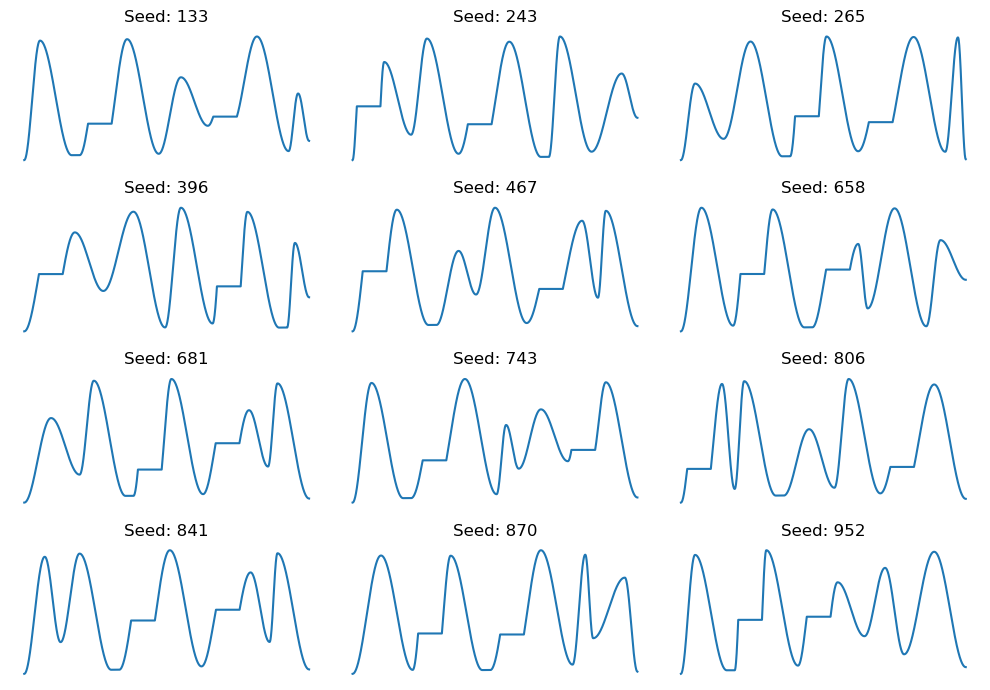

In [13]:
stim = StimulusGenerator(config, seed=396)
stim.labels.items()

dict_items([('decreasing_intervals', [(32000, 50000), (69000, 89000), (99000, 119000), (141000, 161000), (171000, 180000)]), ('major_decreasing_intervals', [(69000, 89000), (99000, 119000), (141000, 161000)]), ('increasing_intervals', [(0, 32000), (50000, 69000), (89000, 99000), (119000, 141000), (165900, 171000)]), ('strictly_increasing_intervals', [(50000, 69000), (89000, 99000), (165900, 171000)]), ('plateau_intervals', [(9300, 24300), (121700, 136700)]), ('prolonged_minima_intervals', [(160900, 165900)])])

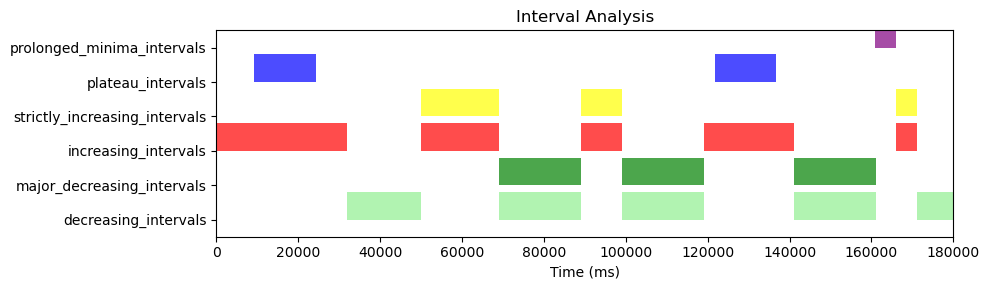

In [14]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

stim = StimulusGenerator(config, seed=396)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 3))

# Define colors for each type of interval
colors = dict(
    zip(stim.labels.keys(), ["lightgreen", "green", "red", "yellow", "blue", "purple"])
)

# Plot patches for each interval type
num_types = len(stim.labels)
for i, (interval_type, intervals) in enumerate(stim.labels.items()):
    for start, end in intervals:
        ax.add_patch(
            patches.Rectangle(
                (start, i),
                end - start,
                0.8,
                facecolor=colors[interval_type],
                edgecolor="none",
                alpha=0.7,
            )
        )

# Set axis limits and stim.labels
ax.set_xlim(0, stim.duration * 1000)
ax.set_ylim(-0.5, num_types - 0.5)
ax.set_xlabel("Time (ms)")
ax.set_yticks(range(num_types))
ax.set_yticklabels(stim.labels.keys())

# Add legend
legend_elements = [
    patches.Patch(facecolor=color, edgecolor="none", alpha=0.7, label=label)
    for label, color in colors.items()
]

# Set title
plt.title("Interval Analysis")

# Show plot
plt.tight_layout()
